In [1]:
import torch
from datasets import load_dataset
from torchvision import transforms
import torchvision
import torch.nn.functional as F
import torch.nn as nn
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import OrderedDict
from transformers import AutoImageProcessor, ViTMAEForPreTraining

E:\anaconda3\envs\pytorch\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: Could not find module 'E:\anaconda3\envs\pytorch\lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
dataset = load_dataset("Isamu136/big-animal-dataset")
train_dataset = dataset["train"]
print(train_dataset)

Dataset({
    features: ['image', 'caption'],
    num_rows: 62149
})


In [3]:
train_size = 100
train_dataset = train_dataset.shuffle(seed=42).select(range(train_size))

In [4]:
print(train_size)
caption_to_label = {}
label_to_caption = {}

caption_set = list(set(train_dataset["caption"]))
for i in range(0, len(caption_set)):
    caption_to_label[caption_set[i]] = i
    label_to_caption[i] = caption_set[i]
    
    
    
num_classes = max(label_to_caption.keys()) + 1
print(num_classes)
print(label_to_caption)

100
50
{0: 'keeshond', 1: 'schipperke', 2: 'Abyssinian', 3: 'miniature pinscher', 4: 'Irish_wolfhound', 5: 'Cardigan', 6: 'chicken', 7: 'sheep', 8: 'otterhound', 9: 'cocker_spaniel', 10: 'cat', 11: 'Blenheim_spaniel', 12: 'groenendael', 13: 'Samoyed', 14: 'Shetland_sheepdog', 15: 'cow', 16: 'samoyed', 17: 'Norwich_terrier', 18: 'African_hunting_dog', 19: 'american pit bull terrier', 20: 'wheaten terrier', 21: 'horse', 22: 'bluetick', 23: 'dhole', 24: 'EntleBucher', 25: 'Pembroke', 26: 'Pekinese', 27: 'curly-coated_retriever', 28: 'squirrel', 29: 'Bouvier_des_Flandres', 30: 'Boston_bull', 31: 'Norfolk_terrier', 32: 'boxer', 33: 'basenji', 34: 'Maine Coon', 35: 'Birman', 36: 'West_Highland_white_terrier', 37: 'beagle', 38: 'elephant', 39: 'dog', 40: 'collie', 41: 'butterfly', 42: 'Pomeranian', 43: 'Newfoundland', 44: 'spider', 45: 'Bengal', 46: 'miniature_schnauzer', 47: 'leonberger', 48: 'Egyptian Mau', 49: 'Maltese_dog'}


In [5]:
image_size = 224
image_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),    # Resize to the target size
    transforms.ToTensor(),          # Convert to a PyTorch tensor
])

class MyCustomDataset(torch.utils.data.Dataset):
    def __init__(self, your_data_here):
        self.data = your_data_here

    def __len__(self):
        return len(self.data['image'])

    def __getitem__(self, idx):
        return {
            'image': image_transform(self.data['image'][idx]),
            'caption': self.data['caption'][idx],
            'label': caption_to_label[self.data['caption'][idx]],
        }
    
# Finally create the dataloader
my_train_dataset = MyCustomDataset(train_dataset)
train_dataloader = torch.utils.data.DataLoader(my_train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

**Try the huggingface model**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0107, grad_fn=<DivBackward0>)
torch.Size([1, 196, 768])
torch.Size([1, 196])
torch.Size([1, 196])


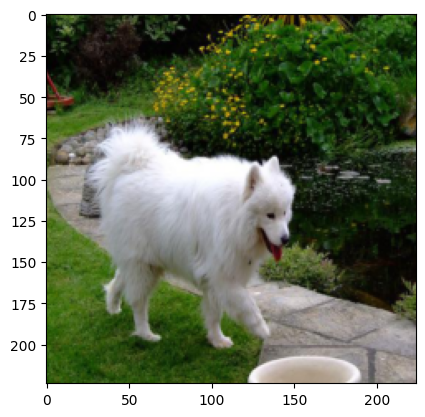

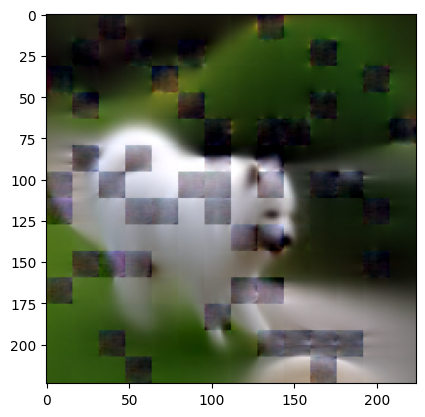

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base").to(device)

test_image = image_transform(train_dataset["image"][0])
test_output = model(test_image.unsqueeze(0))
loss, logits, mask, ids_restore = test_output.loss, test_output.logits, test_output.mask, test_output.ids_restore
print(loss)
print(logits.shape)
print(mask.shape)
print(ids_restore.shape)

bs, seq_len, hidden_dim = logits.shape
window_size = int((hidden_dim // 3) ** 0.5)
pred = logits.reshape(bs, 14, 14, 16, 16, 3)
pred = pred.permute(0, 5, 1, 3, 2, 4)
pred = pred.reshape(bs, 3, 224, 224)

def plot_image(t):
    image_np = t.numpy()
    image_np = image_np.transpose(1, 2, 0)
    plt.imshow(image_np)

plt.figure(0)
plot_image(test_image)
plt.figure(1)
plot_image(pred[0].detach())

**Make our own model**

torch.Size([1, 196, 768])
torch.Size([1, 3, 224, 224])


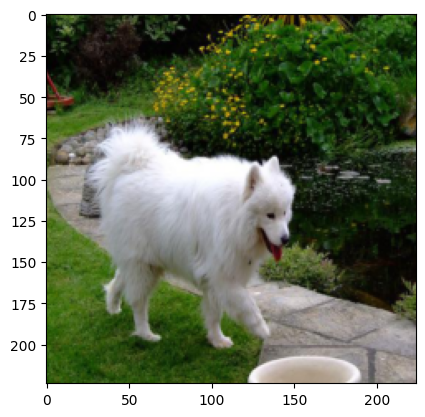

In [7]:
def patchify(image, patch_size):
    bs, n_channels, height, width = image.shape
    num_patches_height = height // patch_size
    num_patches_width = width // patch_size
    embedding = image.reshape(bs, n_channels, num_patches_height, patch_size, num_patches_width, patch_size)
    embedding = embedding.permute(0, 2, 4, 3, 5, 1)
    embedding = embedding.reshape(bs, num_patches_height*num_patches_width, patch_size*patch_size*n_channels)
    return embedding

patch_embeddings = patchify(test_image.unsqueeze(0), 16)
print(patch_embeddings.shape)
    

def unpatchify(patch_embeddings, patch_size):
    bs, seq_len, embedding_dim = patch_embeddings.shape
    n_channels = int(embedding_dim // (patch_size**2))
    patched_height = patched_width = int(seq_len**0.5)

    height, width = patched_height * patch_size, patched_width * patch_size
    
    image = patch_embeddings.reshape(bs, patched_height, patched_height, patch_size, patch_size, n_channels)
    image = image.permute(0, 5, 1, 3, 2, 4)
    image = image.reshape(bs, n_channels, height, width)
    return image
    
    
recovered_images = unpatchify(patch_embeddings, 16)
print(recovered_images.shape)
plot_image(recovered_images[0].detach())

In [197]:
def GetPositionEmbedding1D(sequence_indices, embedding_len):
    div = 10000 ** (torch.arange(0, embedding_len // 2) * 2 / embedding_len)
    positions = sequence_indices.unsqueeze(1)
    pos_emb = torch.zeros(sequence_indices.shape[0], embedding_len)
    pos_emb[:, 0::2] = torch.sin(positions / div)
    pos_emb[:, 1::2] = torch.cos(positions / div)
    return pos_emb

def GetPositionEmbedding2D(image_size, embedding_dim, add_cls=False):
    pos_emb = torch.zeros(image_size*image_size, embedding_dim)
    coord = torch.stack(torch.meshgrid(torch.arange(0, image_size), torch.arange(0, image_size))) # 2 * W * H
    coord = coord.view(coord.shape[0], -1)
    height_embedding = GetPositionEmbedding1D(coord[0], embedding_dim // 2)  # embedding for 0000111122223333
    width_embedding = GetPositionEmbedding1D(coord[1], embedding_dim // 2)   # embedding for 0123012301230123
    pos_emb[:, embedding_dim//2:] = height_embedding
    pos_emb[:, :embedding_dim//2] = width_embedding
    # Now each embedding has both width and height information
    if add_cls:
        pos_emb = torch.cat([torch.zeros([1, embedding_dim]), pos_emb], axis=0)
    
    return pos_emb
    
print(GetPositionEmbedding2D(5, 4, add_cls=True).shape)

torch.Size([26, 4])


In [202]:
class MultiheadAttentionBlock(nn.Module):
    def __init__(self, embed_size, num_heads, p=0.2):
        super(MultiheadAttentionBlock, self).__init__()

        self.embed_size = embed_size
        self.num_heads = num_heads
        self.head_dim = embed_size // num_heads

        self.query = nn.Linear(embed_size, embed_size)
        self.key = nn.Linear(embed_size, embed_size)
        self.value = nn.Linear(embed_size, embed_size)
        self.dropout = nn.Dropout(p)
        self.linear = nn.Linear(embed_size, embed_size)

    def forward(self, query, key, value, mask=None):
        N = query.shape[0]

        query = self.query(query)
        key = self.key(key)
        value = self.value(value)

        query = query.view(N, -1, self.num_heads, self.head_dim)
        key = key.view(N, -1, self.num_heads, self.head_dim)
        value = value.view(N, -1, self.num_heads, self.head_dim)

        query = query.permute(0, 2, 1, 3)
        key = key.permute(0, 2, 1, 3)
        value = value.permute(0, 2, 1, 3)

        scores = torch.matmul(query, key.permute(0, 1, 3, 2)) / torch.sqrt(
            torch.tensor(self.head_dim, dtype=torch.float32)
        )

        if mask is not None:
            scores = scores.masked_fill(mask == 0, float("-1e20"))

        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)

        output = torch.matmul(attention_weights, value)
        output = output.permute(0, 2, 1, 3).contiguous()
        output = output.view(N, -1, self.embed_size)

        output = self.linear(output)
        return output, attention_weights


class VitMAEMultiheadSelfAttention(nn.Module):
    def __init__(self, hidden_dim, num_heads):
        super(VitMAEMultiheadSelfAttention, self).__init__()
#         self.attention_layer = nn.MultiheadAttention(hidden_dim, num_heads, dropout=0.2, batch_first=True)
        self.attention_layer = MultiheadAttentionBlock(hidden_dim, num_heads, p=0.2)
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x, mask=None):        
        context, atten_prob = self.attention_layer(x, x, x)
        return self.dropout(context), atten_prob
    
    
class VitMAEEncoderORDecoderBlock(nn.Module):
    def __init__(self, num_layers, dim, dense_dim, num_heads):
        super(VitMAEEncoderORDecoderBlock, self).__init__()
        
        self.layernorm1 = nn.LayerNorm(dim)

        self.attention = VitMAEMultiheadSelfAttention(dim, num_heads)
                
        self.linear1 = nn.Linear(dim, dense_dim)
        self.activation = nn.GELU()
        
        self.linear2 = nn.Linear(dense_dim, dim)
        self.dropout1 = nn.Dropout(0.2)
        
        self.layernorm2 = nn.LayerNorm(dim)
        
    def forward(self, hidden_states):
        
        attention_output, atten_prob = self.attention(self.layernorm1(hidden_states))
        
        hidden_states = hidden_states + attention_output
        layer_out = self.layernorm2(hidden_states)
        
        layer_out = self.linear1(layer_out)
        layer_out = self.activation(layer_out)
        
        layer_out = self.linear2(layer_out)
        layer_out = self.dropout1(layer_out)
        layer_out = layer_out + hidden_states
        
        return layer_out

class VitMAEEncoder(nn.Module):
    def __init__(self, num_encoder_layers=11, encoder_dim=768, encoder_dense_dim=3073, num_heads=8):
        super(VitMAEEncoder, self).__init__()
        
        encoders = OrderedDict()
        for i in range(num_encoder_layers):
            encoders[f"encoder_layer_{i}"] = VitMAEEncoderORDecoderBlock(num_encoder_layers, encoder_dim, encoder_dense_dim, num_heads)
        self.encoders = nn.Sequential(encoders)
        
        self.ln = nn.LayerNorm(encoder_dim)
        
    def forward(self, patch_embedding):
        return self.ln(self.encoders(patch_embedding))

    
class VitMAEDecoder(nn.Module):
    # patch_embedding_width: squre root of len of patch embedding len
    # patch_depth: dim of a patch
    def __init__(self, patch_embedding_width, patch_depth, patch_width, num_decoder_layers=8, decoder_dim=512, decoder_dense_dim=2048, num_heads=8):
        super(VitMAEDecoder, self).__init__()
        
        self.patch_embedding_width = patch_embedding_width
        
        self.position_embedding = nn.Parameter(GetPositionEmbedding2D(patch_embedding_width, decoder_dim, add_cls=True).unsqueeze(0), requires_grad=False)
        # For padding masked elements
        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_dim))
        torch.nn.init.normal_(self.mask_token, std=0.2)

        decoders = OrderedDict()
        for i in range(num_decoder_layers):
            decoders[f"decoder_layer_{i}"] = VitMAEEncoderORDecoderBlock(num_decoder_layers, decoder_dim, decoder_dense_dim, num_heads)
        self.decoders = nn.Sequential(decoders)
    
        self.ln = nn.LayerNorm(decoder_dim)
        self.linear = nn.Linear(decoder_dim, patch_width * patch_width * 3)
        
        
    def forward(self, patch_embedding, ids_restore, mask):
        mask_tokens = self.mask_token.repeat(patch_embedding.shape[0], self.patch_embedding_width**2 + 1 - patch_embedding.shape[1], 1)
        
        filled_masked_sequence = torch.cat([patch_embedding[:, 1:, :], mask_tokens], dim=1)
        
        unshuffled_sequence = torch.gather(filled_masked_sequence, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, patch_embedding.shape[2]))
        unshuffled_sequence = torch.cat([patch_embedding[:, :1, :], unshuffled_sequence], dim=1)

        hidden_states = unshuffled_sequence + self.position_embedding

        return self.linear(self.ln(self.decoders(hidden_states)))[:, 1:, :]
    
    
class VitMAEModel(nn.Module):
    def __init__(self, image_size=224, patch_size=16, mask_percentage=0.75, num_encoder_layers=11, encoder_dim=768, encoder_dense_dim=3073, num_decoder_layers=8,  decoder_dim=512, decoder_dense_dim=2048, num_heads=8):
        super(VitMAEModel, self).__init__()
                
        # Embedding
        self.mask_percentage = mask_percentage
        self.patch_size = patch_size
        
        self.image_to_patch_embedding_conv2d = nn.Conv2d(in_channels=3, out_channels=encoder_dim, kernel_size=patch_size, stride=patch_size)
        w = self.image_to_patch_embedding_conv2d.weight.data
        torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))
        
        self.position_embedding = nn.Parameter(GetPositionEmbedding2D((image_size//patch_size), encoder_dim, add_cls=True).unsqueeze(0), requires_grad=False)
        
        self.cls_token = nn.Parameter(torch.zeros(1, 1, encoder_dim))
        torch.nn.init.normal_(self.cls_token, std=0.2)
        
        # Encoder
        self.encoder = VitMAEEncoder(num_encoder_layers, encoder_dim, encoder_dense_dim, num_heads)

        
        # Decoder
        self.decoder_embedding_layer = nn.Linear(encoder_dim, decoder_dim)
        self.decoder = VitMAEDecoder((image_size//patch_size), patch_size * patch_size * 3, patch_size, num_decoder_layers, decoder_dim, decoder_dense_dim, num_heads)
                
    def random_masking(self, patch_embedding):
        # We make a random noise and then sort it to obtain a list of random indices. Then we sort random indices list to obtain the restore list
        # We then gather the sequence elements with the first %25 random indices so that other %75 elements are discarded (masked).
        batch_size, seq_length, dim = patch_embedding.shape
        len_keep = int(seq_length * (1 - self.mask_percentage))

        noise = torch.rand(batch_size, seq_length, device=patch_embedding.device)  # noise in [0, 1]

        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        ids_keep = ids_shuffle[:, :len_keep]
        patch_embedding_unmasked = torch.gather(patch_embedding, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, dim))

        # We use ids_restore to reture the first %25 0s so that each 0 goes back to the original place.
        mask = torch.ones([batch_size, seq_length], device=patch_embedding.device)
        mask[:, :len_keep] = 0
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return patch_embedding_unmasked, mask, ids_restore
        
    def image_to_patch_embedding(self, image):
        patch_embedding = self.image_to_patch_embedding_conv2d(image)

        patch_embedding = patch_embedding.reshape(patch_embedding.shape[0], patch_embedding.shape[1], -1).permute(0, 2, 1)
        patch_embedding = patch_embedding + self.position_embedding[:, 1:, :]
        patch_embedding_unmasked, mask, ids_restore = self.random_masking(patch_embedding)

        cls_token = self.cls_token + self.position_embedding[:, :1, :]
        cls_tokens = cls_token.expand(patch_embedding_unmasked.shape[0], -1, -1)
        patch_embedding = torch.cat([cls_tokens, patch_embedding_unmasked], dim=1)
        
        return patch_embedding, mask, ids_restore
    
    def forward(self, image, get_recovered=False):
        patch_embedding, mask, ids_restore = self.image_to_patch_embedding(image)
        
        # Encoder
        encoder_output = self.encoder(patch_embedding)
        
        # Decoder
        decoder_embedding = self.decoder_embedding_layer(encoder_output)
        decoder_output = self.decoder(decoder_embedding, ids_restore, mask)
                        
        # The mask is for the sequence, so it's hard to recover the image. Thus, we transform the original image.
        altered_target = patchify(image, self.patch_size)
        loss = (((decoder_output - altered_target) ** 2) * mask.unsqueeze(-1)).sum()
        
        recovered_image = None
        if get_recovered:
            recovered_image = unpatchify(decoder_output, self.patch_size)
        
        return decoder_output, loss, recovered_image
        

In [203]:
test = torch.rand(5, 3, 224, 224)
model_test = VitMAEModel()
output = model_test(test)
print(output)

(tensor([[[-1.7239e-02, -2.5585e-01, -1.6880e+00,  ...,  9.8734e-01,
          -7.3437e-01,  4.3448e-01],
         [-2.5067e-01, -3.4321e-01, -1.2946e+00,  ...,  5.4348e-01,
          -4.9826e-01,  2.2475e-01],
         [ 1.1843e-01, -1.1321e-01, -1.0652e+00,  ...,  1.1219e+00,
          -5.3364e-01,  5.0448e-01],
         ...,
         [-1.6307e-01, -8.1444e-01,  1.5444e-01,  ..., -3.9894e-01,
          -7.1546e-01,  6.8038e-01],
         [-1.7659e-02, -5.7162e-01, -2.6650e-01,  ...,  4.7751e-01,
          -5.2160e-01,  4.4197e-01],
         [-3.0546e-01, -2.5985e-01, -1.3106e+00,  ...,  7.8317e-01,
          -1.2457e+00,  1.4860e-01]],

        [[ 3.7242e-01, -4.2223e-01, -1.4668e+00,  ...,  7.9441e-01,
          -5.1571e-01,  3.5289e-01],
         [-2.8654e-02, -1.3014e-02, -1.6516e+00,  ...,  6.3875e-01,
          -4.9153e-01, -3.2544e-02],
         [-5.1504e-03, -3.0171e-01, -1.2783e+00,  ...,  7.8273e-01,
          -3.6751e-01,  2.4840e-01],
         ...,
         [ 3.4562e-01, -

In [204]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VitMAEModel().to(device)
print(model)

VitMAEModel(
  (image_to_patch_embedding_conv2d): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): VitMAEEncoder(
    (encoders): Sequential(
      (encoder_layer_0): VitMAEEncoderORDecoderBlock(
        (layernorm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attention): VitMAEMultiheadSelfAttention(
          (attention_layer): MultiheadAttentionBlock(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.2, inplace=False)
            (linear): Linear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.2, inplace=False)
        )
        (linear1): Linear(in_features=768, out_features=3073, bias=True)
        (activation): GELU(approximate='none')
        (linear2): Linear(in_features=3073, out_features=768, bi

In [206]:
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

images = None
labels = None

iters = 100
loss_list = []
for iter in tqdm(range(0, iters)):
    iter_loss = 0
    for i, data_batch in enumerate(train_dataloader):
        images = data_batch["image"].to(device)
        labels = data_batch["label"].to(device)
        
        pred, loss, recovered_image = model(images, get_recovered=False)
        iter_loss += loss.data
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print("aaaaaaaaaaa")
        
    loss_list.append(iter_loss)

  0%|          | 0/100 [00:00<?, ?it/s]

aaaaaaaaaaa
aaaaaaaaaaa
aaaaaaaaaaa
aaaaaaaaaaa


KeyboardInterrupt: 